### Import all the Dependencies

In [2]:

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from IPython.display import HTML

# Set all the constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=2

### Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


### Visualization of data

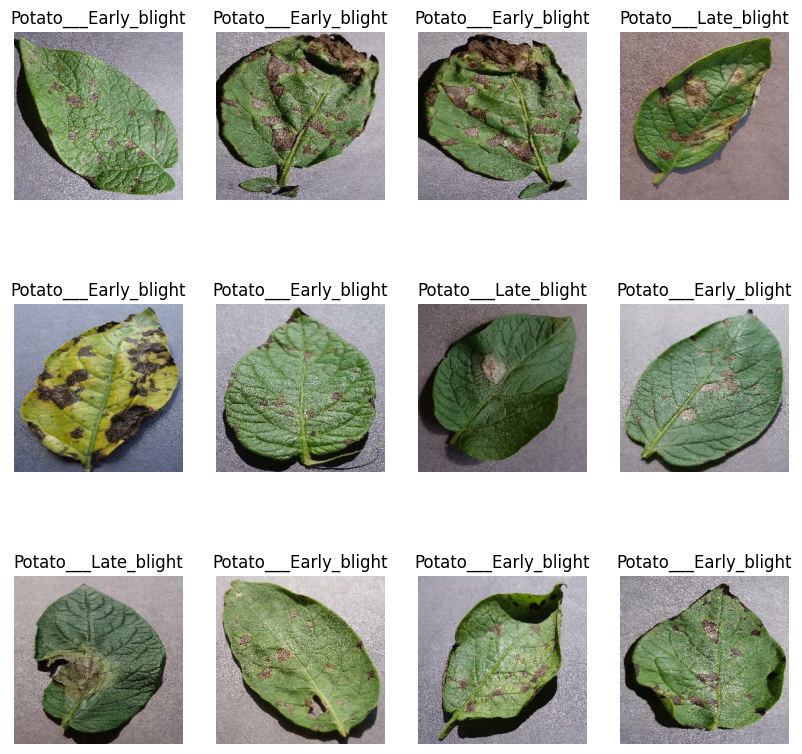

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training(80%)
2. Validation: Dataset to be tested against while training(10%)
3. Test: Dataset to be tested against after we trained a model(10%)

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


### Cache, Shuffle, and Prefetch the Dataset

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
from tensorflow.keras.applications import VGG16

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Load the VGG16 model without the top (classification) layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
base_model.trainable = False

# Create the model
model = models.Sequential([
    resize_and_rescale,
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build((None,)+input_shape)  # Specify the input shape explicitly




In [15]:
# # Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                      

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)


Epoch 1/10


C:\Users\vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 [==============================] - 183s 3s/step - loss: 0.9335 - accuracy: 0.4682 - val_loss: 0.9046 - val_accuracy: 0.4896
Epoch 2/10
54/54 [==============================] - 171s 3s/step - loss: 0.9001 - accuracy: 0.4734 - val_loss: 0.9024 - val_accuracy: 0.4896
Epoch 3/10
54/54 [==============================] - 171s 3s/step - loss: 0.9025 - accuracy: 0.4566 - val_loss: 0.9100 - val_accuracy: 0.4375
Epoch 4/10
54/54 [==============================] - 167s 3s/step - loss: 0.9040 - accuracy: 0.4838 - val_loss: 0.9040 - val_accuracy: 0.4375
Epoch 5/10
54/54 [==============================] - 169s 3s/step - loss: 0.9038 - accuracy: 0.4734 - val_loss: 0.9042 - val_accuracy: 0.4375
Epoch 6/10
54/54 [==============================] - 167s 3s/step - loss: 0.9001 - accuracy: 0.4890 - val_loss: 0.9036 - val_accuracy: 0.4896
Epoch 7/10
54/54 [==============================] - 170s 3s/step - loss: 0.9013 - accuracy: 0.4624 - val_loss: 0.9056 - val_accuracy: 0.4375
Epoch 8/10
54/54 [======

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 22s 3s/step - loss: 0.8959 - accuracy: 0.5000


In [19]:
scores


[0.8958766460418701, 0.5]

In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
len(history.history['loss'])

10

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

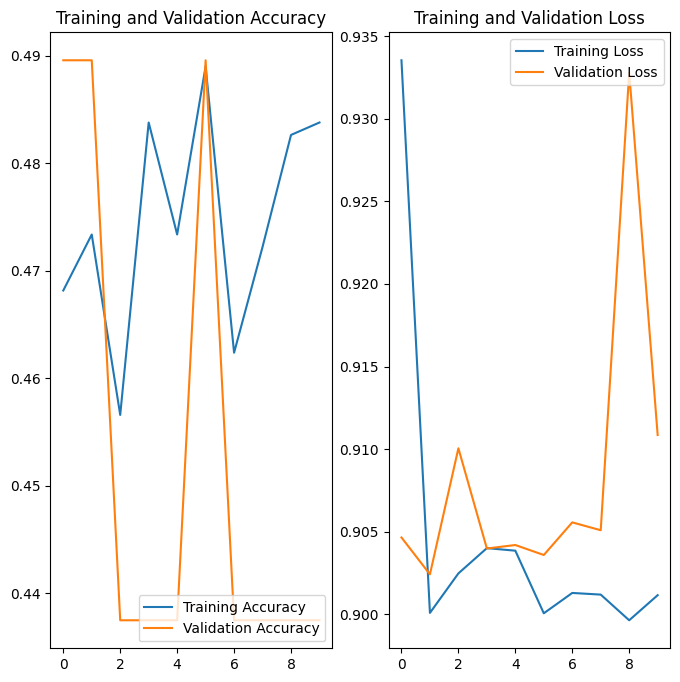

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Late_blight


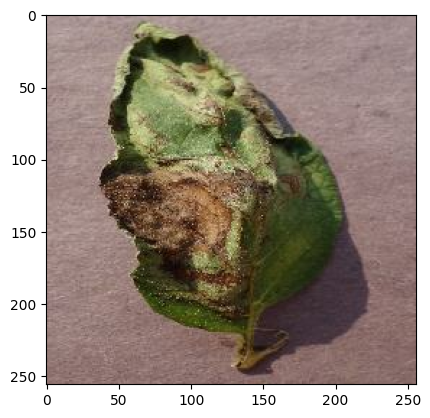

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Run the inference on the sample images

1/1 [==============================] - 0s 103ms/step


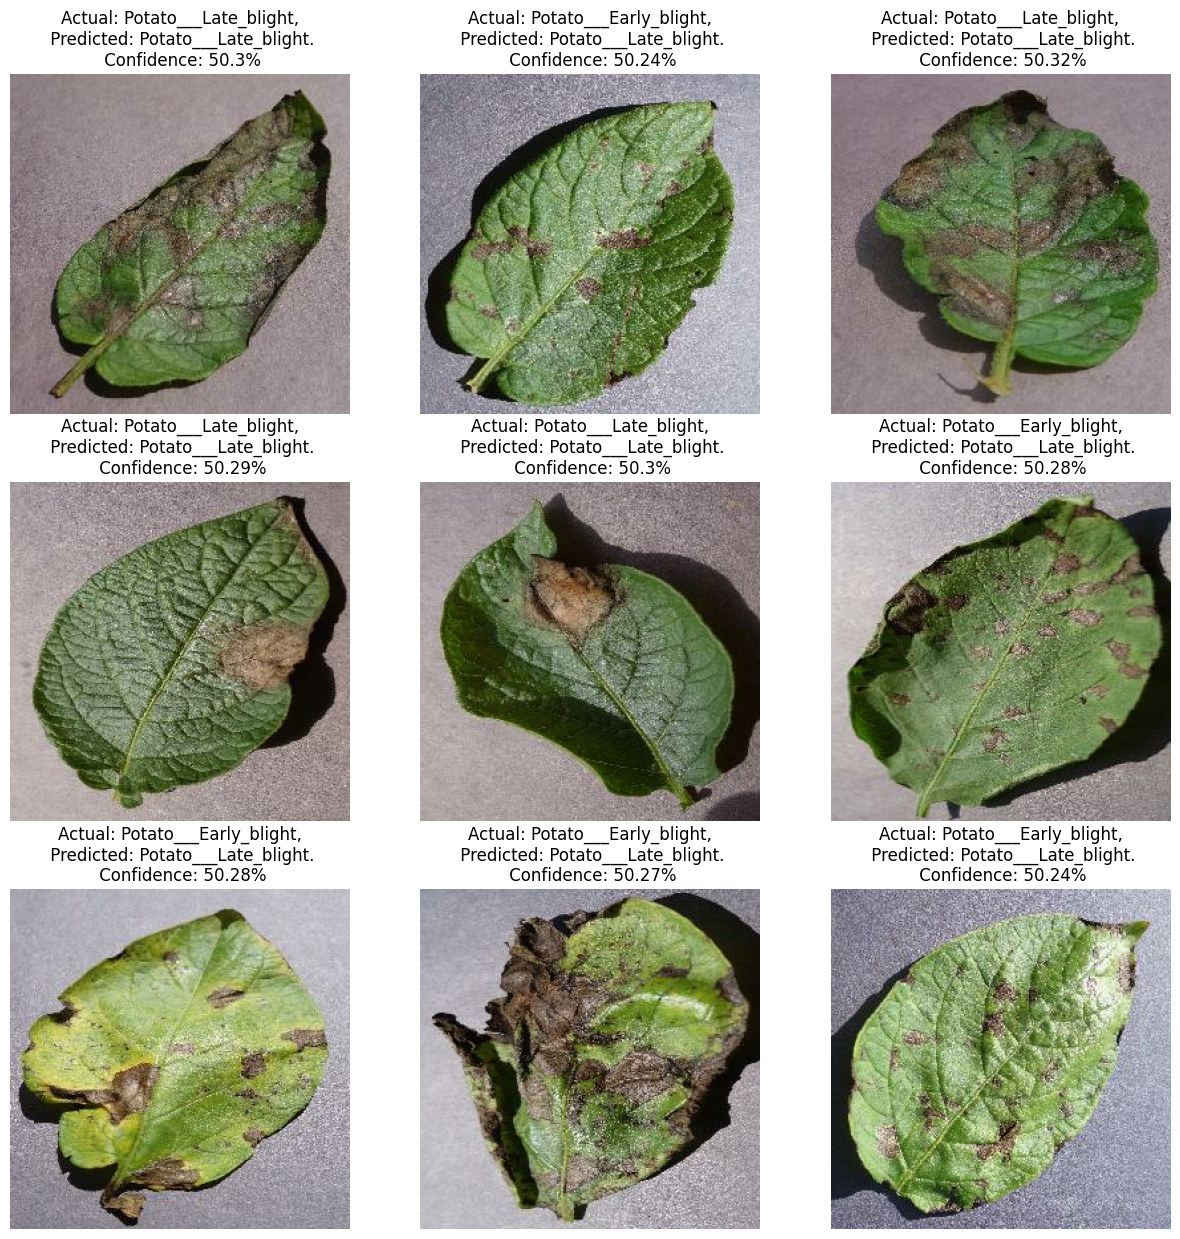

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [1]:
from fastai.vision import *
from fastai.metrics import accuracy
# from fastai.vision import get_transforms

import cv2

# Define the paths to your train, validation, and test datasets
path = '/path/to/your/dataset'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Define the image size and number of channels
IMAGE_SIZE = 256
CHANNELS = 3

# Define the data augmentation transformations
tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=20.0, max_zoom=1.2, max_lighting=0.4)

# Create the ImageDataBunch for training, validation, and test
data = ImageDataBunch.from_folder(path, train=train_dir, valid=val_dir, test=test_dir, ds_tfms=tfms, size=IMAGE_SIZE, bs=BATCH_SIZE, num_workers=4).normalize(imagenet_stats)

# Create the VGG16 model
model = models.vgg16_bn(pretrained=True)

# Replace the last fully connected layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, data.c)

# Create the learner
learn = Learner(data, model, metrics=[accuracy])

# Train the model
learn.fit_one_cycle(EPOCHS)

# Get the predictions and targets
preds, y = learn.get_preds()

# Create the interpretation object
interp = ClassificationInterpretation(learn, preds, y, losses=nn.CrossEntropyLoss)


NameError: name 'aug_transforms' is not defined

In [2]:
import torch
from fastai.vision import *
from fastai.metrics import accuracy

# Define the paths to your train, validation, and test datasets
path = 'C:\Users\vivek\Desktop\sem4\IT258-DS\projejct_code\potato-disease-classification-main\PlantVillage'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Define the image size and number of channels
IMAGE_SIZE = 256
CHANNELS = 3

# Define the data augmentation transformations
tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=20.0, max_zoom=1.2, max_lighting=0.4)

# Create the DataBlock with ImageBlock and CategoryBlock
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name=train_dir, valid_name=val_dir),
    get_y=parent_label,
    item_tfms=Resize(IMAGE_SIZE),
    batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)]
)

# Create the DataLoaders
dls = data.dataloaders(path, bs=BATCH_SIZE, num_workers=4)

# Create the VGG16 model
model = models.vgg16_bn(pretrained=True)

# Replace the last fully connected layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, dls.c)

# Create the learner
learn = Learner(dls, model, metrics=accuracy)

# Train the model
learn.fit_one_cycle(EPOCHS)

# Get the predictions and targets
preds, y = learn.get_preds()

# Create the interpretation object
interp = ClassificationInterpretation(learn, preds, y, loss_func=CrossEntropyLossFlat())


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3404466146.py, line 6)